In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [9]:
INPUT_DIR = "/Users/claracelestechavezcotrina/Downloads/DATA_TESIS/inbreast"
OUTPUT_DIR = "/Users/claracelestechavezcotrina/Downloads/DATA_TESIS/INbreast_preprocessed"

TARGET_SIZE = (224, 224)
BIRADS_TO_USE = ["birads3", "birads4", "birads5"]

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [10]:
# FX: Recorte automático de la mama
def crop_breast(image):
    # Binarización suave para detectar la mama
    _, thresh = cv2.threshold(image, 5, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    
    if not contours:
        return image
    
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    return image[y:y+h, x:x+w]

In [11]:
# FX: Normalización por percentiles
def percentile_normalization(image, p_low=1, p_high=99):
    low = np.percentile(image, p_low)
    high = np.percentile(image, p_high)
    
    image = np.clip(image, low, high)
    image = (image - low) / (high - low)
    image = (image * 255).astype(np.uint8)
    
    return image

In [12]:
# FX :CLAHE suave (RECOMENDADO)
def apply_clahe(image):
    clahe = cv2.createCLAHE(
        clipLimit=2.0,        # suave
        tileGridSize=(8, 8)
    )
    return clahe.apply(image)


In [13]:
# Preprocesamiento
def preprocess_image(img_path):
    # Leer imagen
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    
    # Recorte de mama
    img = crop_breast(img)
    
    # Normalización
    img = percentile_normalization(img)
    
    # CLAHE
    img = apply_clahe(img)
    
    # Resize
    img = cv2.resize(img, TARGET_SIZE)
    
    return img


In [14]:
# Preprocesamiento del dataset
for birads in BIRADS_TO_USE:
    input_class_dir = os.path.join(INPUT_DIR, birads)
    output_class_dir = os.path.join(OUTPUT_DIR, birads)
    os.makedirs(output_class_dir, exist_ok=True)
    
    images = os.listdir(input_class_dir)
    
    for img_name in tqdm(images, desc=f"Procesando {birads}"):
        input_path = os.path.join(input_class_dir, img_name)
        output_path = os.path.join(output_class_dir, img_name)
        
        processed_img = preprocess_image(input_path)
        
        if processed_img is not None:
            cv2.imwrite(output_path, processed_img)

Procesando birads5: 100%|██████████| 57/57 [00:05<00:00,  9.80it/s]


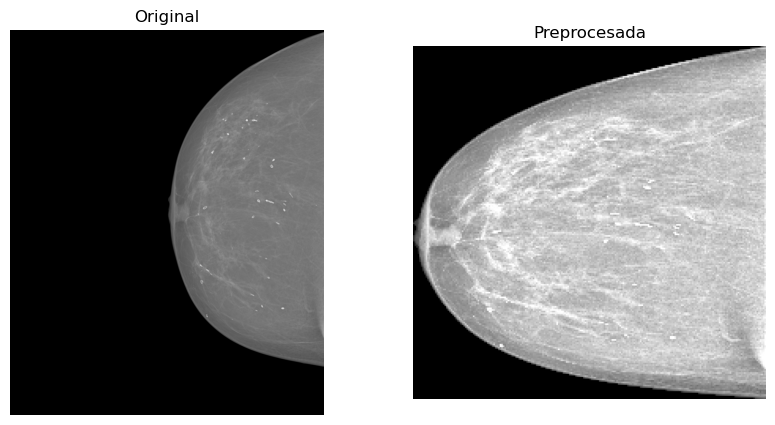

In [15]:
import matplotlib.pyplot as plt

sample_path = os.path.join(INPUT_DIR, "birads3", os.listdir(os.path.join(INPUT_DIR, "birads3"))[0])

original = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
processed = preprocess_image(sample_path)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(original, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Preprocesada")
plt.imshow(processed, cmap="gray")
plt.axis("off")

plt.show()

# Codigo para renombrar las imagenes de las carpertas

In [18]:
import os

In [21]:
# Ruta raíz donde están las carpetas birads
root_dir = "/Users/claracelestechavezcotrina/Downloads/DATA_TESIS/datasetPublico_preprocesado_etapa2"

# Extensiones de imagen permitidas
valid_exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

In [23]:
for birads in sorted(os.listdir(root_dir)):
    birads_path = os.path.join(root_dir, birads)

    if not os.path.isdir(birads_path):
        continue

    print(f"\nProcesando {birads}...")

    counter = 1  # numeración continua por clase

    for split in ["train", "val", "test"]:
        split_path = os.path.join(birads_path, split)

        if not os.path.isdir(split_path):
            continue

        images = sorted([
            f for f in os.listdir(split_path)
            if f.lower().endswith(valid_exts)
        ])

        for img in images:
            ext = os.path.splitext(img)[1]
            new_name = f"{birads}_{counter}{ext}"

            old_path = os.path.join(split_path, img)
            new_path = os.path.join(split_path, new_name)

            os.rename(old_path, new_path)
            counter += 1

    print(f"✔ {counter - 1} imágenes renombradas en {birads}")



Procesando birads3...
✔ 23 imágenes renombradas en birads3

Procesando birads4...
✔ 43 imágenes renombradas en birads4

Procesando birads5...
✔ 57 imágenes renombradas en birads5
